# MIP Control

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib notebook  
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [3]:
from ctrl.system.tf import PID
from ctrl.block.linear import MIMO, ShortCircuit, Subtract, Differentiator
from ctrl.block.logger import Logger
from ctrl.block.nl import Abs
from ctrl.block.logic import CompareAbs, Trigger
from ctrl.system.tf import DTTF
from ctrl.system.ss import DTSS

# Initialize the server on the beagblebone
python3 server.py -H 192.168.12.197 -m mip2 -t 0.02

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [4]:
from ctrl.client import Controller
HOST, PORT = "localhost", 9999
#HOST, PORT = "192.168.12.197", 9999
mip = Controller(host = HOST, port = PORT)

## Probe the controller

In [5]:
print(mip.info('all'))

> Controller with 6 device(s), 8 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. imu
  6. is_running
  7. motor1
  8. motor2
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[InclinometerRaw, enabled] >> imu
> filters
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. motor2 >> motor2[Motor, enabled]



## Closed-loop Control

In [6]:
mip.add_signal('phi_dot')

mip.add_filter('phi_dot', 
               Differentiator(),
               ['clock','encoder1'], 
               ['phi_dot'])

In [7]:
mip.add_signal('theta_dot_reference')
mip.add_signal('phi_dot_reference')
mip.add_signal('voltage')

mip.set_signal('theta_dot_reference', 0)
mip.set_signal('phi_dot_reference', 0)

mip.add_signal('theta_dot_error')
mip.add_signal('phi_dot_error')

mip.add_filter('sub_theta', 
               Subtract(),
               ['imu','theta_dot_reference'], 
               ['theta_dot_error'])

mip.add_filter('sub_phi', 
               Subtract(),
               ['phi_dot','phi_dot_reference'], 
               ['phi_dot_error'])

In [49]:
Ac = np.array([[0.915597, 0.0302843],
               [-0.0798062, 0.991456]])
Bc = 2*np.pi*np.array([[0.00264873, -0.000392888],
                       [0.00192947, -0.00130486]])
Cc = np.array([[-382.025, 251.309]])
Dc = 2*np.pi*np.array([[-1.19947, 0]])

Bc = (100/7.4)*Bc
Dc = (100/7.4)*Dc

K = 1.3

ctrl = DTSS(Ac,K*Bc,Cc,K*Dc)

In [50]:
mip.add_filter('controller', 
               MIMO(ctrl),
               ['theta_dot_error','phi_dot_error'], 
               ['voltage'])

In [51]:
mip.add_filter('cl1',
                ShortCircuit(),
               ['voltage'],
               ['motor1'])
mip.add_filter('cl2',
                ShortCircuit(),
               ['voltage'],
               ['motor2'])

#mip.remove_filter('cl1')
#mip.remove_filter('cl2')

In [52]:
mip.add_sink('logger', 
             Logger(), 
             ['clock',
              'imu','motor1','motor2','encoder1','encoder2',
              'voltage','duty',
              'theta_dot_error','phi_dot_error',
              'phi_dot'])

In [53]:
print(mip.info('all'))

> Controller with 6 device(s), 14 signal(s), 4 source(s), 3 sink(s), and 6 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. imu
  6. is_running
  7. motor1
  8. motor2
  9. phi_dot
  10. phi_dot_error
  11. phi_dot_reference
  12. theta_dot_error
  13. theta_dot_reference
  14. voltage
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[InclinometerRaw, disabled] >> imu
> filters
  1. clock, encoder1 >> phi_dot[Differentiator, enabled] >> phi_dot
  2. imu, theta_dot_reference >> sub_theta[Subtract, enabled] >> theta_dot_error
  3. phi_dot, phi_dot_reference >> sub_phi[Subtract, enabled] >> phi_dot_error
  4. theta_dot_error, phi_dot_error >> controller[MIMO, enabled] >> voltage
  5. voltage >> cl1[ShortCircuit, enabled] >> motor1
  6. voltage >> cl

In [54]:
mip.set_sink('logger',reset=True)
mip.set_source('clock',reset=True)
mip.set_source('encoder1',reset=True)
mip.set_source('encoder2',reset=True)
mip.set_filter('controller',reset=True)
with mip:
    time.sleep(10)
log = mip.read_sink('logger')

In [39]:
clock = log[:,0]
theta_dot = log[:,1]
motor1 = log[:,2]
motor2 = log[:,3]
encoder1 = log[:,4]
encoder2 = log[:,5]
voltage = log[:,6]
duty = log[:,7]
theta_dot_error = log[:,8]
phi_dot_error = log[:,9]
phi_dot = log[:,10]

data = {
    'clock': clock,
    'theta_dot': theta_dot,
    'phi_dot': phi_dot,
    'encoder1': encoder1,
    'encoder2': encoder2,
    'voltage': voltage
}

<IPython.core.display.Javascript object>


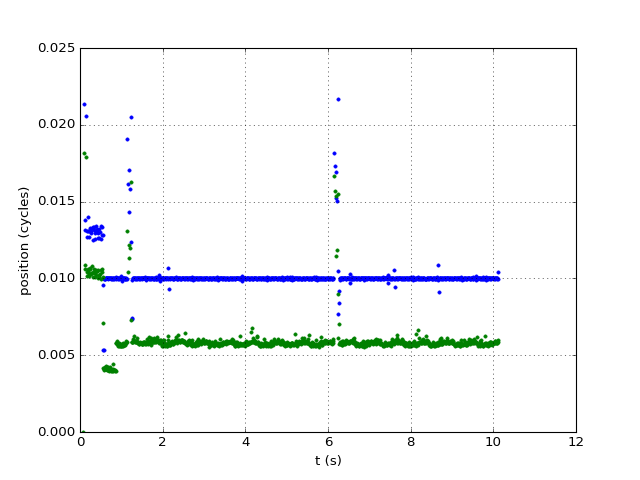

In [40]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock[1:],clock[1:]-clock[:-1], '.',clock,duty,'.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
#plt.xlim(0,1)

<IPython.core.display.Javascript object>


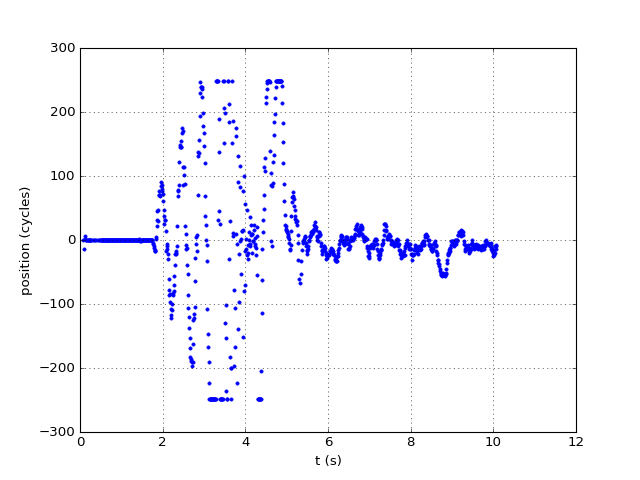

In [29]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,theta_dot*360,'b.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
#plt.xlim(0,2.45)
#plt.xlim(0,3)

<IPython.core.display.Javascript object>


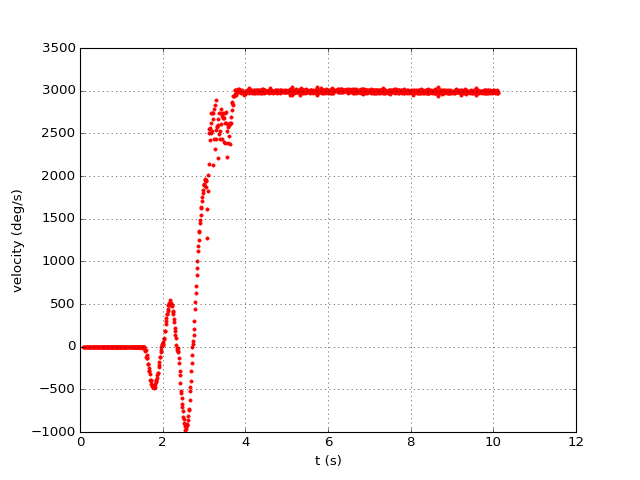

In [41]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,phi_dot*360,'r.')
plt.xlabel('t (s)')
plt.ylabel('velocity (deg/s)')
plt.grid()
#plt.xlim(1.8,2.45)
#plt.ylim(-60,65)

<IPython.core.display.Javascript object>


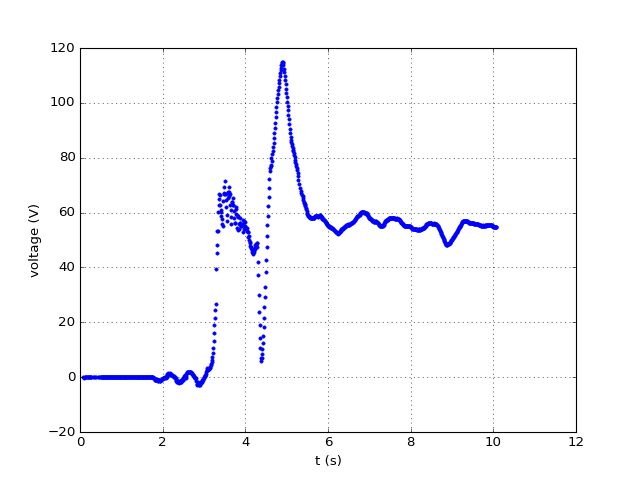

In [20]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,(7.4/100)*voltage,'b.')
plt.xlabel('t (s)')
plt.ylabel('voltage (V)')
plt.grid()

In [42]:
import scipy.io as spio
spio.savemat(file_name='/home/mauricio/Dropbox/ZhuZhuo/python', mdict = data)